# 

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch
import gc
import psutil
import GPUtil


# Enable MLflow autologging for PyTorch
#mlflow.pytorch.autolog() not working
mlflow.set_tracking_uri(uri="file:///C:/Users/jcwin/OneDrive - University of Southampton/_Southampton/2024-25/Star-Classifier/mlflow")
mlflow.set_experiment("Gaia_FullyconnectedNN")

<Experiment: artifact_location=('file:///C:/Users/jcwin/OneDrive - University of '
 'Southampton/_Southampton/2024-25/Star-Classifier/mlflow/810326884881464967'), creation_time=1729260093028, experiment_id='810326884881464967', last_update_time=1729260093028, lifecycle_stage='active', name='Gaia_FullyconnectedNN', tags={}>

In [72]:
# Custom Dataset for handling balanced data
class BalancedDataset(Dataset):
    def __init__(self, X, y, limit_per_label=1600):
        self.X = X
        self.y = y
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.indices = self.balance_classes()

    def balance_classes(self):
        indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        np.random.shuffle(indices)
        return indices

    def re_sample(self):
        self.indices = self.balance_classes()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return self.X[index], self.y[index]
# Custom Dataset for validation with limit per class
class BalancedValidationDataset(Dataset):
    def __init__(self, X, y, limit_per_label=400):
        self.X = X
        self.y = y
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.indices = self.balance_classes()

    def balance_classes(self):
        indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        np.random.shuffle(indices)
        return indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return self.X[index], self.y[index]


# Updated train_model function with system metrics logging
def train_model(model, train_loader, val_loader, test_loader, num_epochs=10, lr=1e-4, patience=5, device='cuda'):
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    early_stopping_counter = 0
    best_test_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Re-sample the training dataset at the start of each epoch
        train_loader.dataset.re_sample()
        
        model.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_accuracy = (outputs.argmax(dim=1) == y_batch).float().mean()
            train_loss += loss.item() * X_batch.size(0)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        test_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                val_accuracy = (outputs.argmax(dim=1) == y_val).float().mean()
                loss = criterion(outputs, y_val)
                val_loss += loss.item() * X_val.size(0)
        # test loss
        with torch.no_grad():
            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)
                outputs = model(X_test)
                loss = criterion(outputs, y_test)
                test_loss += loss.item() * X_test.size(0)
                test_accuracy = (outputs.argmax(dim=1) == y_test).float().mean()
        
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        test_loss /= len(test_loader.dataset)

        

        # Log metrics to MLflow
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_accuracy.item(), step=epoch)
        mlflow.log_metric("train_accuracy", train_accuracy.item(), step=epoch)
        mlflow.log_metric("test_loss", test_loss, step=epoch)
        mlflow.log_metric("test_accuracy", test_accuracy.item(), step=epoch)
        
        # Log system metrics
        log_system_metrics(epoch)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        
        # Early stopping
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered.")
                break
    
    return model
def log_system_metrics(epoch):
    cpu_usage = psutil.cpu_percent()
    memory_info = psutil.virtual_memory()
    gpus = GPUtil.getGPUs()
    
    if gpus:
        for i, gpu in enumerate(gpus):
            mlflow.log_metric(f"gpu_{i}_usage", gpu.load * 100, step=epoch)
            mlflow.log_metric(f"gpu_{i}_memory_used", gpu.memoryUsed, step=epoch)
            mlflow.log_metric(f"gpu_{i}_memory_total", gpu.memoryTotal, step=epoch)
    
    mlflow.log_metric("cpu_usage", cpu_usage, step=epoch)
    mlflow.log_metric("memory_usage", memory_info.percent, step=epoch)

# Confusion matrix and classification report
def print_confusion_matrix(model, val_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            preds = model(X_batch).cpu().numpy()
            all_preds.extend(np.argmax(preds, axis=1))
            all_labels.extend(y_batch.numpy())

    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['Star', 'Binary Star', 'Galaxy', 'AGN'], 
                yticklabels=['Star', 'Binary Star', 'Galaxy', 'AGN'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Main script to load data and train the model
if __name__ == "__main__":
    # Load and preprocess data
    X = pd.read_pickle("Pickles/fusionv0/train.pkl")
    y = X["label"]
    label_mapping = {'star': 0, 'binary_star': 1, 'galaxy': 2, 'agn': 3}
    y = y.map(label_mapping).values
    columns = ["parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", "pmra", "pmdec", "pmra_error", "pmdec_error", 
           "phot_g_mean_flux", "flagnopllx", "phot_g_mean_flux_error", "phot_bp_mean_flux", "phot_rp_mean_flux", 
           "phot_bp_mean_flux_error", "phot_rp_mean_flux_error"]
    X = X[columns]
    
    # Read test data
    X_test = pd.read_pickle("Pickles/fusionv0/test.pkl")
    y_test = X_test["label"].map(label_mapping).values
    X_test = X_test[columns]

    # Convert test data to torch tensors
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)  # Convert DataFrame to NumPy array first
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create the test dataset without the unsqueeze
    test_dataset = BalancedValidationDataset(X_test_tensor, y_test_tensor)

    # Create the DataLoader
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Clear memory
    del X, y
    gc.collect()

    # Convert to torch tensors and create datasets
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    X_val = torch.tensor(X_val.values, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)
    train_dataset = BalancedDataset(X_train, y_train)
    val_dataset = BalancedValidationDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

In [55]:
# Define the fully connected neural network with modular architecture based on list of hidden layer sizes
# This is a simple feedforward neural network with ReLU activations and dropout
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 128, 64], num_classes=4):
        super(FCNN, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        
        self.fc_layers = nn.ModuleList()
        in_features = input_size
        for h in hidden_sizes:
            self.fc_layers.append(nn.Linear(in_features, h))
            self.fc_layers.append(nn.ReLU())
            self.fc_layers.append(nn.Dropout(0.2))
            in_features = h
        self.fc_layers.append(nn.Linear(in_features, num_classes))
    
    def forward(self, x):
        x = x.view(-1, self.input_size)
        for layer in self.fc_layers:
            x = layer(x)
        return x

In [73]:
# Assuming your input size is the number of features in your dataset
input_size = 17  # Adjust this based on your actual number of features
num_classes = 4  # Number of classes in your classification problem

model = FCNN(input_size=17, hidden_sizes=[64, 128, 512, 512,512, 128, 64], num_classes=4)

print(model)
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))


FCNN(
  (fc_layers): ModuleList(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=512, out_features=512, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.2, inplace=False)
    (15): Linear(in_features=512, out_features=128, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.2, inplace=False)
    (18): Linear(in_features=128, out_features=64, bias=True)
    (19): ReLU()
    (20): Dropout(p=0.2, inplace=False)
    (21): Linear(in_features=64, out_features=4, bias=True)
  )
)
Number of parameters: 675012


In [74]:
# Now you can use your train_model function with this model
with mlflow.start_run(log_system_metrics=True): 
    trained_model = train_model(model, train_loader, val_loader, test_loader, num_epochs=500, lr=1e-4, patience=20)

2024/10/18 16:01:42 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch 1/500, Train Loss: 1.3773, Val Loss: 1.3691, Val Accuracy: 0.2916, Test Loss: 1.3711, Test Accuracy: 0.2500
Epoch 2/500, Train Loss: 1.3561, Val Loss: 1.3318, Val Accuracy: 0.6575, Test Loss: 1.3304, Test Accuracy: 0.8250
Epoch 3/500, Train Loss: 1.2958, Val Loss: 1.2230, Val Accuracy: 0.4521, Test Loss: 1.2113, Test Accuracy: 0.4750
Epoch 4/500, Train Loss: 1.1746, Val Loss: 1.0870, Val Accuracy: 0.4344, Test Loss: 1.0650, Test Accuracy: 0.4500
Epoch 5/500, Train Loss: 1.0784, Val Loss: 1.0047, Val Accuracy: 0.6536, Test Loss: 0.9827, Test Accuracy: 0.8000
Epoch 6/500, Train Loss: 1.0061, Val Loss: 0.9060, Val Accuracy: 0.6517, Test Loss: 0.8799, Test Accuracy: 0.8500
Epoch 7/500, Train Loss: 0.8987, Val Loss: 0.7932, Val Accuracy: 0.6497, Test Loss: 0.7624, Test Accuracy: 0.7500
Epoch 8/500, Train Loss: 0.8028, Val Loss: 0.6950, Val Accuracy: 0.6517, Test Loss: 0.6596, Test Accuracy: 0.7750
Epoch 9/500, Train Loss: 0.7242, Val Loss: 0.6336, Val Accuracy: 0.6693, Test Loss: 0.59

2024/10/18 16:03:02 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/10/18 16:03:02 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Epoch 242/500, Train Loss: 0.3964, Val Loss: 0.3863, Val Accuracy: 0.8278, Test Loss: 0.3726, Test Accuracy: 0.8000
Early stopping triggered.


Confusion Matrix:
[[277 114   1   8]
 [ 40 357   0   3]
 [  0   0 372   4]
 [  2   3  60 335]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77       400
           1       0.75      0.89      0.82       400
           2       0.86      0.99      0.92       376
           3       0.96      0.84      0.89       400

    accuracy                           0.85      1576
   macro avg       0.86      0.85      0.85      1576
weighted avg       0.86      0.85      0.85      1576



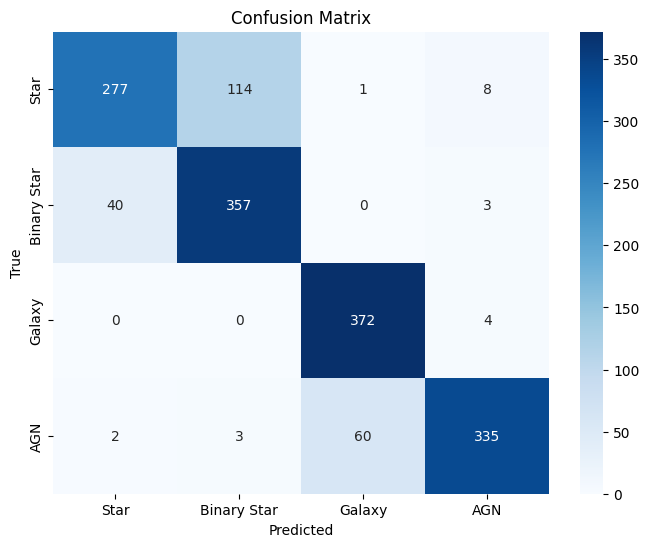

In [65]:
# Evaluate with confusion matrix and classification report
print_confusion_matrix(trained_model, test_loader)